# Deep Learning Model


In [2]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [4]:
# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

In [5]:
# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print('Number of available GPUs:', len(tf.config.list_physical_devices('GPU')))

TF Version: 2.7.0
Keras Version: 2.7.0
Number of available GPUs: 0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Read the data
df = pd.read_csv('/content/drive/My Drive/ML_NLP/covid_articles_preprocessed.csv')

## Merge Tags

tag_map = {'consumer':'general',
           'healthcare':'science',
           'automotive':'business',
           'environment':'science',
           'construction':'business',
           'ai':'tech'}

df['tags'] = [(lambda tags: tag_map[tags] if tags in tag_map.keys() else tags)(tags)
                          for tags in df['topic_area']]
df.tags.value_counts()

business    245652
general      86372
finance      22386
tech          8915
science       5595
Name: tags, dtype: int64

In [8]:
X = df.content.tolist()
y = df.tags.values

enc = LabelEncoder()
y = enc.fit_transform(y)
enc_tags_mapping = dict(zip(enc.transform(enc.classes_), enc.classes_))

## Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=21)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_validation = tokenizer.texts_to_sequences(X_validation)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [10]:
maxlen = 470

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_validation = pad_sequences(X_validation, padding='post', maxlen=maxlen)

In [11]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Dropout(rate=0.2, seed=21))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5, seed=21))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 470, 50)           46890800  
                                                                 
 dropout (Dropout)           (None, 470, 50)           0         
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 512)               26112     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                        

In [18]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [12]:
checkpoint_path = "/content/drive/My Drive/ML_NLP/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
my_callbacks = [
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
                ]


history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_validation, y_validation),
                    batch_size=5000,
                    callbacks=[my_callbacks])

model.save('/content/drive/My Drive/ML_NLP/saved_model/my_model')

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 1.2189 - accuracy: 0.6531
Epoch 00001: saving model to /content/drive/My Drive/ML_NLP/training_1/cp.ckpt
42/42 [==============================] - 94s 2s/step - loss: 1.2189 - accuracy: 0.6531 - val_loss: 0.9167 - val_accuracy: 0.6689
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 0.8714 - accuracy: 0.6662
Epoch 00002: saving model to /content/drive/My Drive/ML_NLP/training_1/cp.ckpt
42/42 [==============================] - 93s 2s/step - loss: 0.8714 - accuracy: 0.6662 - val_loss: 0.7817 - val_accuracy: 0.7041
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7727
Epoch 00003: saving model to /content/drive/My Drive/ML_NLP/training_1/cp.ckpt
42/42 [==============================] - 103s 2s/step - loss: 0.7039 - accuracy: 0.7727 - val_loss: 0.6187 - val_accuracy: 0.8004
Epoch 4/50
42/42 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.8109

Training Accuracy: 0.9816
Validation Accuracy:  0.9088


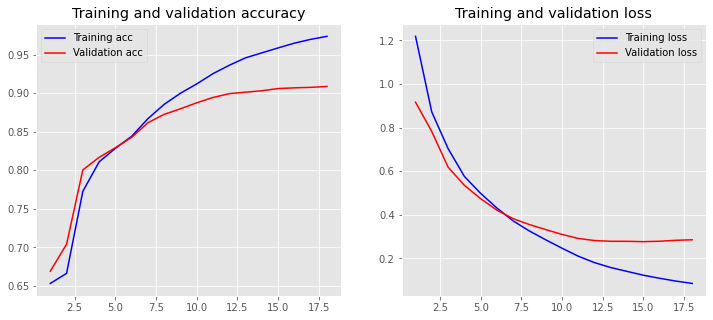

In [19]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [34]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred, target_names=list(enc_tags_mapping.values())))

              precision    recall  f1-score   support

    business       0.93      0.95      0.94     73935
     finance       0.86      0.77      0.81      6788
     general       0.88      0.88      0.88     25646
     science       0.67      0.44      0.53      1690
        tech       0.66      0.55      0.60      2617

    accuracy                           0.91    110676
   macro avg       0.80      0.72      0.75    110676
weighted avg       0.91      0.91      0.91    110676



## Altenative method of creating embeddings

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
layers?

In [ ]:
vectorize_layer.adapt(X_train)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
#text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = X_train[0], y_train[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

In [ ]:
train_ds = map(vectorize_text, X_train)
val_ds = map(vectorize_text, X_validation)
test_ds = map(vectorize_text, X_test)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)